In [92]:
import math
import pickle
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv,pinv
import matplotlib.pyplot as plt
import sys
from IPython import display
import time
import traceback
%matplotlib inline

__author__ = 'Kiks'

def triM(*args):
    startM=args[0]
    for m in args[1:]:
        startM=startM.dot(m)
    return startM

def getX_min(x_row,o_row,timeD):
    xn1=x_row[0]+o_row[1]*math.cos(x_row[2])*timeD
    yn1=x_row[1]+o_row[1]*math.sin(x_row[2])*timeD
    thet1=turnAng(x_row[2]+o_row[2]*timeD,(o_row,x_row,timeD ))
    return np.array([xn1,yn1,thet1])
def getHfun(curX,lanX):
    v=math.sqrt((curX[0]-lanX[0])**2+(curX[1]-lanX[1])**2)
    w=math.atan2(lanX[1]-curX[1],lanX[0]-curX[0])-turnAng( curX[2])
    return np.array([v, turnAng(w)])

def getH(curX,lanX,Hfun):
    VpoX=(curX[0]-lanX[0])/(Hfun[0])
    VpoY=(curX[1]-lanX[1])/(Hfun[0])
    denWder=( (lanX[0]-curX[0])**2 +(lanX[1]-curX[1])**2 )
    
    WpoX=(lanX[1]-curX[1])/denWder
    WpoY=-(lanX[0]-curX[0])/denWder
    
    WpoTh=-1
    return np.array([ [VpoX,VpoY,0],[WpoX,WpoY,-1] ])
    
def getA(x_row,o_row,timeD):
    a=np.eye(3,3)
    a[0,2]=-o_row[1]*math.sin(x_row[2])*timeD
    a[1,2]=o_row[1]*math.cos(x_row[2])*timeD
    return a
def getP_min(AK,PK_1,QK):
    return triM(AK,PK_1,AK.T) + \
    (QK)

def getK(PK_,HK,RK):
    return triM(PK_,HK.T,
           inv(  triM(HK,PK_,HK.T)
                   +RK))

def getX_post(x_row,KK,z_row,h_row):
    difZX=(z_row-h_row)
    #print(difZX,KK.shape, difZX.shape)
    corX=triM(KK, difZX)
    corX[2]=turnAng(corX[2],(x_row,KK,difZX))
    
    pX=x_row+corX
    pX[2]=turnAng(pX[2],(x_row,triM(KK,difZX)) )
    return pX

def getP(I,KK,HK,PK_):
    return  (I- np.dot(KK,HK)).dot(PK_)
def absdist(x1,x2):
    return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])

def getbaseX(groun,odom):
    if len(odom)<1:
        print('no ground baseX')
        sys.exit(-5)
    fin=np.where(groun[:,0]<=odom[0,0])[0]
    if len(fin)<1:
        print("no baseX for first odom")
        sys.exit(-5)
        #return getbaseX(groun,odom[1:])
    return fin[-1]
def euc_dist(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 )
def  getGrounForOdom(groun,odom):
    resL=[]
    for o in odom:
        res=np.where(groun[:,0]>=o[0])[0]
        if len(res)<1:
            print('this o:',o)
            resL.append(-1)
        else:
            resL.append(res[0])
    return resL
def interp(twoG,time,xAng):
    if np.product(twoG[:,3])<0 and np.abs(twoG[0,3])>3.0:
        indS=0
        #print('inside 1',twoG)
        if twoG[1,3]*xAng>0:
            indS=1
        difT=math.pi-abs(twoG[1-indS,3])
        signA=np.sign(xAng)
        print('here in interp',twoG[indS,3],twoG[indS,3]+(signA*difT),xAng,twoG[1-indS,3])
        twoG[1-indS,3]=twoG[indS,3]+(signA*difT)
        #print('inside 2',twoG)    
    rat=(time-twoG[0,0])/(twoG[1,0]-twoG[0,0])
    return (rat)*twoG[1,1:]+(1-rat)*twoG[0,1:]
def turnAng(x,why=False):
    if abs(x)>2*math.pi:
        print('non valid angle',why,x)
        x=(abs(x)/x)*abs(x)%(2*math.pi)
        #sys.exit(-10)
    elif abs(x)>math.pi:
        return x-((abs(x)/x)*2*math.pi)
    return x
def isMulti(meas,ind,lenM,lanDik):
    if ind<lenM-1 and meas[ind,0]==meas[ind+1,0] and  int(meas[ind+1,1]) in lanDik:
        return True
    else: 
        return False
def shouldCorrect(mind,kolkuM):
    if mind!=0 or (kolkuM!=0):
        return True
    return False
invZO=lambda a: a+(1-a)-(1*a)
class binTable:
    def __init__(self,table=None,alternate=None):
        self.table=table
        self.alternate=alternate
        if self.alternate is not None:
            return
        self.nBin=len(table)
        self.first=table[0,0]
        self.last=table[-1,0]
        self.dif=table[1,0]-table[0,0]
    def getNoise(self,angl=None):
        if self.alternate is not None:
            return self.alternate
        uncbinNum=((angl-self.first)/self.dif)
        binNum=int(np.ceil( np.clip(uncbinNum,0,self.nBin-1)))
        return self.table[binNum,1]
    

In [93]:
def getAll(i=3):

    
    oName='datasets/Robot{}_Odometry.dat'.format(i)
    mName='datasets/Robot{}_Measurement.dat'.format(i)
    gName='datasets/Robot{}_Groundtruth.dat'.format(i)
    lName='datasets/Landmark_Groundtruth.dat'
    bName='datasets/Barcodes.dat'

    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')

    namesLand=" Subject#    x[m]    y[m]    xstd-dev[m]    ystd-dev[m]".split()
    land=pd.read_csv(lName,sep=r"\s*",skiprows=4,names=namesLand,engine='python')

    namesBar=" Subject#    Barcode#".split()
    bar=pd.read_csv(bName,sep=r"\s*",skiprows=4,names=namesBar,engine='python')

    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    land=np.array(land.values)
    bar=np.array(bar.values)
    
    barDik={int(row[0]):int(row[1]) for row in bar}
    landDik={barDik[int(row[0])]:row[1:3] for row in land}
    
    return odom,meas,groun,landDik

In [109]:
def process(groun,odom,meas,btwn_Ms,lanDik,GForO,Qerror,distBin,anglBin,isCorrect=True):
    fInd1=getbaseX(groun,odom)
    #print(fInd1)
    #sys.exit(-6)
    
    xCalc=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    xCalc[0]=groun[fInd1,1:]
    curTime=groun[fInd1,0]
    
    xTime=np.zeros((odom.shape[0]+1,),dtype=float)
    xTime[0]=curTime
    
    dist=np.zeros((odom.shape[0],3))
    startInd=0
    lenM=len(meas)
    # PMat=np.zeros((odom.shape[0]+1,odom.shape[1]),dtype=float)
    PMat=np.zeros((3,3),dtype=float)

    QMat=Qerror
    #RMat=Rerror[2]* invZO(np.eye(2)) +np.eye(2)*Rerror[:2]
    #HMat=np.eye(3)
    IMat=np.eye(3,3)

    postEd=np.zeros((odom.shape[0]+1,),dtype=int)
    postEd[0]=1
    
    hFun=np.zeros((0,))
    hMat=np.zeros((0,3))
    RCol=np.zeros((0,1))
    howManyM=0
    kolkuNeProv=0
    tempP=[]
    for i,mind in enumerate(np.array(btwn_Ms,dtype=int)):
        for insInd in range(startInd,startInd+mind):
            timeD=odom[insInd,0]-curTime
            xCalc[insInd+1]=getX_min(xCalc[insInd],odom[insInd],timeD)
            xTime[insInd+1]=odom[insInd,0]
            
            # This index is insInd because GForO is 1 shorter
            li=GForO[insInd]
            if li!=-1:
                xt=interp(groun[li-1:li+1],xTime[insInd+1],xCalc[insInd+1,2])
                dist[insInd]=(xt-xCalc[insInd+1])
                #this turns the angle
                dist[insInd,2]=turnAng(dist[insInd,2],True)
                if insInd==26243:
                    print('this is diff ground',xt,xTime[insInd+1],xCalc[insInd+1],dist[insInd,2])
            else:
                kolkuNeProv+=1
            curA=getA(xCalc[insInd+1],odom[insInd],timeD)
            PMat=getP_min(curA,PMat,QMat)

            curTime=odom[insInd,0]
        startInd+=mind
        # alllow 0 odom measurments when they are a landmark, afrter some other
        # to go with one land replace should Correct with mind!=0 and 
        # disable is Multi to be false always
        if isCorrect and shouldCorrect(mind,howManyM)  and i<lenM and  int(meas[i][1]) in lanDik:
            postEd[startInd]=1
            #print(startInd,xCalc[startInd],PMat)
            
            inhFun=getHfun(xCalc[startInd],lanDik[ int(meas[i][1]) ])
            inHMat=getH(xCalc[startInd],lanDik[ int(meas[i][1])],inhFun)
            
            hFun=np.hstack((hFun,inhFun))
            hMat=np.vstack((hMat,inHMat))
            howManyM+=1
            
            RCol=np.vstack((RCol,distBin.getNoise(meas[i,3]),
                            anglBin.getNoise()  ))
            
            if True or not isMulti(meas,i,lenM,lanDik):
                RMat=np.eye(2*(howManyM))*RCol
                tempP.append(howManyM)
                try:
                    KMat=getK(PMat,hMat,RMat)
                except:
                    traceback.print_exc()
                    print(i,howManyM,RMat,hMat,PMat)
                    sys.exit(-10)
                tmpMeas=meas[i-howManyM+1:i+1,2:].flatten()
                
                #print(i,howManyM,hFun.shape,hFun,meas[i-howManyM+1:i+1,2:].shape,hFun,hFun.shape)
                xCalc[startInd]=getX_post(xCalc[startInd],KMat,
                                          tmpMeas,
                                          hFun)

                # This index is 1 shorter
                li=GForO[startInd-1]
                if li!=-1:
                    xt=interp(groun[li-1:li+1],xTime[startInd],xCalc[startInd,2])
                    dist[startInd-1]=(xt-xCalc[startInd])
                    # this turns the angle
                    dist[startInd-1,2]=turnAng(dist[startInd-1,2])
                
                #print("\n============\n",getK(PMat,HMat,RMat))
                PMat=getP(IMat,KMat,hMat,PMat)
                
                #reset hfun and hmat
                hFun=np.zeros((0,))
                hMat=np.zeros((0,hMat.shape[1]))
                RCol=np.zeros((0,1))
                howManyM=0
            
            #print('\n\n===================\n',
            #      startInd,xCalc[startInd],KMat,PMat,HMat,hFun,meas[i,:],meas[i][2:]-hFun)
            #sys.exit(-20)
    print('average how many ',np.average(tempP))      
    return postEd,xCalc,xTime,fInd1,dist,kolkuNeProv

In [110]:
i=3
np.set_printoptions(precision=12)

odom,meas,groun,landDik=getAll(i)


print(len(meas),len(set(meas[:,0])))



with open('betw_{}.meas'.format(i),"rb") as f:
    bt_Ms,abt_Ms=pickle.load(f)

with open('betw_{}.groun'.format(i),"rb") as f:
    bt_Gt=pickle.load(f)

print(landDik)
aBinName,dBinName='angle.bins','distance.bins'

with open(aBinName,"rb") as f:
    aBin=pickle.load(f)

with open(dBinName,"rb") as f:
    dBin=pickle.load(f)

startI=0
startO=sum(abt_Ms[:startI])

#print(startI,sum(abt_Ms[startI:]),len(odom[startO:]),len(abt_Ms),len(meas))
#plt.figure(figsize=(20,10))
#plt.plot(abt_Ms[7135:])

if 'gOdomS' not in globals():
    gOdomS=getGrounForOdom(groun,odom)


print(gOdomS[:10],'gOdomS' in globals())

# Rerror=[1e-1,1e-2,0] best results, [1.8e-2,1.8e-3,0] sligthly better results
# Rerror=[ 0.018226805545 ,0.001896513236, 0.000182973795 ] diff meas error result

#Qerror=np.eye(3)*[4.795327766111 , 5.765323033782 , 2.200884690961]

Qerror=np.array([[ 4.795327766111, -3.067588863282 ,-1.524742487505],
 [-3.067588863282,  5.765323033782 , 1.244378647301],
 [-1.524742487505,  1.244378647301 , 2.200884690961]])

#Qerror=np.array([[ 0.073425589113, -0.018860480262,  0.004337329666],
# [-0.018860480262 , 0.030964563617, -0.000117006372],
# [ 0.004337329666, -0.000117006372,  0.012225012533]])

postEd,xCalc,xTime,fInd,dist,kolkuNeP=process(groun,odom[startO:],meas[startI:],
                                abt_Ms[startI:],landDik,gOdomS,Qerror,dBin,aBin,True)

tvarD=sum((dist -np.mean(dist,0))**2)/(len(dist)-1)
varD,meanD=np.var(dist,0),np.mean(dist,0)


print("Ne se provereni: {}".format(kolkuNeP),tvarD,varD,sum(abt_Ms),len(dist))
#postEdO,xCalcO,xTimeO,fIndO=process(groun,odom[startO:],meas[startI:],
#                                abt_Ms[startI:],landDik,False,Qerror=1e-5,1e-1)

#plotAll(groun,xCalc,xTime,postEd,200,len(groun),[[-1,6],[-6.5,6.5]],timeStep=0.8)


/opt/conda/lib/python3.5/site-packages/pandas/io/parsers.py:1588: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/opt/conda/lib/python3.5/site-packages/pandas/io/parsers.py:1590: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


7720 5102
{36: array([ 3.26730988,  2.52731607]), 70: array([ 4.13634588,  3.60883503]), 7: array([ 4.6723925,  0.8440939]), 72: array([ 2.65345619, -3.75123336]), 9: array([ 0.97259759, -3.19151915]), 45: array([ 0.48704624, -4.95127346]), 16: array([ 0.95289638,  2.7093334 ]), 81: array([ 1.91856554, -0.82058089]), 18: array([ 3.72073503, -1.98025384]), 54: array([ 0.8891764 ,  4.40906195]), 25: array([ 2.39221778,  3.80018838]), 90: array([ 3.12907696, -5.5581163 ]), 27: array([ 0.91765949,  0.59631939]), 61: array([ 2.76327261,  0.24394752]), 63: array([ 0.84527678, -1.61673856])}
[924, 924, 925, 925, 926, 928, 929, 930, 931, 933] True
here in interp -3.1353 -3.15769265359 -3.03215038415 3.1192
here in interp -3.1349 -3.14939265359 -3.04461743466 3.1271
here in interp -3.1365 -3.13809265359 -3.09578526755 3.14
here in interp 3.1325 3.13929265359 3.10864502402 -3.1348
this is diff ground [ 1.890150456    -0.354717741362  3.135696559677] 1248297955.92 [ 1.798019296913 -0.203911497354

[ 6857  6859  6856  6786  6855  6858  6854  6785  6853  6784  6852  6783
  6851  6782  6850  6781 88681  6780 88682 88684]


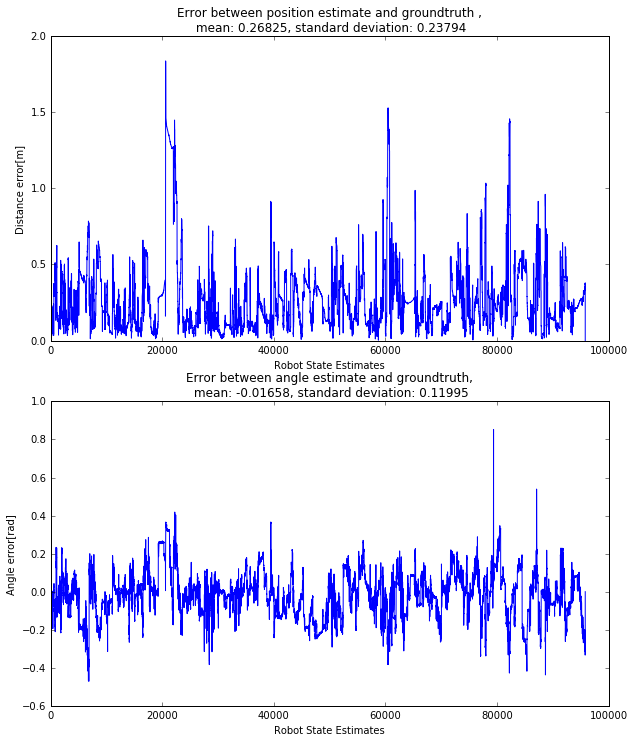

In [111]:
toSave,sName=True,"error_single.png"
doHist=False

plt.figure(figsize=(10,12))

plt.subplot(211)

if doHist:
    plt.title("Histogram of x-axis error,\n mean: {:.05f}, var: {:.05f}".format(meanD[0],varD[0]))
    plt.hist(dist[:,0],bins=500)
else:
    actualEr=np.sqrt(np.sum(dist[:,:2]**2,axis=1))
    plt.title("Error between position estimate and groundtruth ,"
              +"\n mean: {:.05f}, standard deviation: {:.05f}".format(np.average(actualEr),
                                                                                                     np.std(actualEr)))
    plt.ylabel('Distance error[m]')
    plt.xlabel('Robot State Estimates')
    plt.plot(actualEr)


# if toSave:
#     plt.savefig(sName.format(0),dpi=300)
#     plt.clf()
plt.subplot(212)
if doHist:
    plt.title("Histogram of y-axis error,\n mean: {:.05f}, var: {:.05f}".format(meanD[1],varD[1]))
    plt.hist(dist[:,1],bins=500)
else:
    plt.title("Error between angle estimate and groundtruth,"
              +"\n mean: {:.05f}, standard deviation: {:.05f}".format(meanD[2],np.std(dist[:,2])))
    plt.ylabel('Angle error[rad]')
    plt.xlabel('Robot State Estimates')
    plt.plot(dist[:,2])

# if toSave:
#     plt.savefig(sName.format(1),dpi=300)
#     plt.clf()

#plt.subplot(313)
if doHist:
    plt.title("Histogram of angle error,\n mean: {:.05f}, var: {:.05f}".format(meanD[2],varD[2]))
    plt.hist(dist[:,2],bins=500)
else:
    #plt.title("Error between angle estimate and groundtruth,\n mean: {:.05f}, var: {:.05f}".format(meanD[2],varD[2]))
    #plt.plot(dist[:,2])
    tempZ=np.zeros(sum(abt_Ms),)+3
    newAbt=[]
    absS=0
    for ab in abt_Ms[:-1]:
        absS+=ab
        newAbt.append(absS)
    tempZ[newAbt]=3.5
#     plt.subplot(211)
#     plt.plot(tempZ)
#     plt.subplot(311)
#     plt.plot(tempZ)

#oldDist=dist
print(np.argsort(dist[:,2])[:20])

if toSave:
    plt.savefig(sName.format(2),dpi=300)

In [15]:
np.random.seed(1)
sRerror=[0.01822398, 0.00189622,  0.00018295]
#sRerror=[1e-2,1e-3,0]
starteri=np.array([[4e-1,3e-1,1.5e-1],
                  [1e-1,1e-1,1e-1]])
starteri=np.vstack((starteri, np.random.rand(20,3)*2.8))
kolkuStarteri=len(starteri)
for j,ranQ in enumerate(starteri):
    kolkuIterac=20
    print('\n===========================\nstarting value ',ranQ)
    Qerror=np.eye(3)*ranQ
    for i in range(kolkuIterac):
        postEd,xCalc,xTime,fInd,dist,kolkuNeP=process(groun,odom,meas,
                                        abt_Ms,landDik,gOdomS,Qerror,
                                                     dBin,aBin,False)
        disT=dist.T
        disT.shape
        Qerror=np.cov(disT,ddof=0)
        print('\r{}/{} starter; iteracija {}/{}  '.format(j+1,kolkuStarteri,i+1,kolkuIterac),flush=True,end='')
    #print("\n\nMean of dif {}, var of dif: {}".format(np.mean(dist,0),np.var(dist,0)))
    print('\n\ngreska: ',Qerror.diagonal(),'\n\n',Qerror)
# Q Error [ 0.073668167269  0.031574516784  0.011900615829]


starting value  [ 0.4   0.3   0.15]
1/22 starter; iteracija 20/20  

greska:  [ 4.795327766111  5.765323033782  2.200884690961] 

 [[ 4.795327766111 -3.067588863282 -1.524742487505]
 [-3.067588863282  5.765323033782  1.244378647301]
 [-1.524742487505  1.244378647301  2.200884690961]]

starting value  [ 0.1  0.1  0.1]
2/22 starter; iteracija 20/20  

greska:  [ 4.795327766111  5.765323033782  2.200884690961] 

 [[ 4.795327766111 -3.067588863282 -1.524742487505]
 [-3.067588863282  5.765323033782  1.244378647301]
 [-1.524742487505  1.244378647301  2.200884690961]]

starting value  [  1.167661613167e+00   2.016908581638e+00   3.202494885657e-04]
3/22 starter; iteracija 20/20  

greska:  [ 4.795327766111  5.765323033782  2.200884690961] 

 [[ 4.795327766111 -3.067588863282 -1.524742487505]
 [-3.067588863282  5.765323033782  1.244378647301]
 [-1.524742487505  1.244378647301  2.200884690961]]

starting value  [ 0.846531203369  0.410916494288  0.258548065353]
4/22 starter; iteracija 20/20  



In [7]:
"Examine spikes in angle odometry"
np.where(abs(dist[:,2])>1)[0],odom[np.where(abs(dist[:,2])>1)[0],0]

(array([  270, 10432, 10433, 26031, 26243, 31427, 31428, 58003, 79163,
        79361, 80154, 80160, 80180, 80181, 80186, 80194, 80199, 80206,
        80213, 80216, 80221, 85794], dtype=int64),
 array([  1.248297564044e+09,   1.248297710620e+09,   1.248297710630e+09,
          1.248297949651e+09,   1.248297955918e+09,   1.248298045495e+09,
          1.248298045505e+09,   1.248298399401e+09,   1.248298709909e+09,
          1.248298712487e+09,   1.248298722698e+09,   1.248298722770e+09,
          1.248298723026e+09,   1.248298723037e+09,   1.248298723118e+09,
          1.248298723200e+09,   1.248298723272e+09,   1.248298723364e+09,
          1.248298723466e+09,   1.248298723507e+09,   1.248298723578e+09,
          1.248298800906e+09]))

In [6]:
def plotMov(oldG,newG,oldO,newO,oldOO=None,newOO=None):
    #print(oldG.shape,newG.shape,oldO.shape,newO.shape)
    #sys.exit(-5)
    plt.plot(oldG[:,1],oldG[:,2],color=(0.5647,0.933,0.5647,0.7058),linestyle='--')
    plt.plot(newG[:,1],newG[:,2],'g-')
    plt.scatter(newG[-1,1],newG[-1,2],color='green',s=20)
    
    plt.plot(oldO[:,0],oldO[:,1],color= (1.0, 0.6, 0.6),linestyle='--')
    if oldOO!= None: plt.plot(oldOO[:,0],oldOO[:,1],
                              color= (1.0,165/255,0),linestyle='--')
    # magenta where it actually is posted + final dot
    if len(newO)>0:
        koiC=np.where(newO[:,4]>0.0)[0]
        
        plt.scatter(newO[-1,0],newO[-1,1],color='red',s=80)
        plt.scatter(newO[koiC,0],newO[koiC,1],color='magenta',s=20)      
    if  newOO!= None and len(newOO)>0:    
        plt.scatter(newOO[-1,0],newOO[-1,1],color='orange',s=50)
        
    plt.plot(newO[:,0],newO[:,1],'r-')
    if newOO!= None: plt.plot(newOO[:,0],newOO[:,1],
                              color= (1.0,165/255,0))
def plotLand(lanList):
    plt.scatter(lanList[:,0],lanList[:,1],color='blue',s=50)

In [5]:
def plotAll(groun,xCalc,xTime,postEd,stepRun,maxgrounH,xyAxes,timeStep=1,startGroun=50,
            xCalcO=None):
    #maxgrounH=60000
    #timeTh=groun[grounH,0]
    oldG=0
    upper=20
    lower=-20
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape,postEd.shape)

    grounS=groun[fInd:]
    lanList=np.array(list(landDik.values()))

    xCalc2=np.clip(xCalc,lower,upper)
    xCalc3=np.vstack((xCalc2.T,xTime,postEd)).T
    if xCalcO!=None:
        np.clip(xCalcO,lower,upper,xCalcO)
        xCalcO=np.vstack((xCalcO.T,xTime,postEd)).T
    oldpXO=np.zeros((0,2))
    pxCalcO=None
    
    print(xCalc3.shape)
    p1xCalc=xCalc3#[np.where(postEd==1)]
    print(p1xCalc[:5,4]==1.0)
    oldpX=np.zeros((0,2))
    oldPlotG=np.zeros((0,3))

    #p2xCalc=p1xCalc[p1xCalc[:,3]<timeTh,:]
    sites=[]

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(top=0.85)
    axes=plt.gca()
    axes.set_xlim(xyAxes[0])
    axes.set_ylim(xyAxes[1])
    #plt.subplot(211)
    #plt.plot(np.array(p1xCalc[:,3]<timeTh,dtype=int)[:5])
    for ind,i in enumerate(range(startGroun,maxgrounH,stepRun)):
        if ind%1==0: 
            plt.clf()
            axes=plt.gca()
            axes.set_xlim(xyAxes[0])
            axes.set_ylim(xyAxes[1])
        grounH=i
        print('     \r',grounH,end='',flush=True)
        timeTh=grounS[grounH,0]
        timeThp=grounS[oldG,0]
        p3xCalc=p1xCalc[(p1xCalc[:,3]<=timeTh) & (p1xCalc[:,3]>timeThp),:]
        if xCalcO!=None: pxCalcO=xCalcO[(p1xCalc[:,3]<=timeTh) 
                                        & (p1xCalc[:,3]>timeThp),:]
        
        gBatch=grounS[oldG:grounH,:]

        oldG=i
        print(p3xCalc.shape)
        plotMov(oldPlotG,gBatch,oldpX,p3xCalc,oldpXO,pxCalcO)
        plotLand(lanList)
        plt.savefig("animat/frame_"+str(ind),dpi=200)
        
        sites.append([oldG,grounH,timeThp,timeTh,len(p3xCalc)])
        
        oldpX=p3xCalc
        if xCalcO!=None: oldpXO=pxCalcO
        
        oldPlotG=gBatch

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(timeStep)

    #print (sites)
    sites=np.array(sites)

In [85]:
def calcError(groun,fInd,xCalc,xTime,postEd):
    oldG=0
    upper=20
    lower=-20
    sumE=0.0
    print("shapes xcalc and xtime and posted",xCalc.shape,xTime.shape
          ,postEd.shape,flush=True)
    
    grounS=groun[fInd:]
    #np.clip(xCalc,lower,upper)
    txCalc=np.vstack((xCalc.T,xTime,postEd)).T
    for ind,(old,new) in enumerate(zip(grounS,grounS[1:])):
       
        timeThO=old[0]
        timeThN=new[0]
        testxCalc=txCalc[(txCalc[:,3]<=timeThN) & (txCalc[:,3]>timeThO),:]
        
        if len(testxCalc)>0:
            avgX=np.average(testxCalc[:,:2],0)
            avgG=np.average(np.vstack((old[1:],new[1:])),0)
            #print(avgX,avgG,euc_dist(avgX,avgG))
            sumE+=euc_dist(avgX,avgG)
            
        #print(old,new,testxCalc.shape,testxCalc)
        #if ind%10==6: sys.exit(-5)
    return sumE

In [ ]:
def calcErrs(qL=10,rL=10)
    resList=[]
    for indq,q in enumerate(np.linspace(1e-5,1e-2,qL)):
        for r in np.linspace(1e-5,1e-1,rL):
            postEd,xCalc,xTime,fInd=process(groun,odom[startO:],meas[startI:],
                                    abt_Ms[startI:],landDik,Qerror=q,Rerror=r)
            resList.append( (q,r,calcError(groun,fInd,xCalc,xTime,postEd)))
            print(indq,flush=True)
            #sys.exit(-5)

[[  1.00000000e-05   1.00000000e-01   6.48340436e+04]
 [  1.00000000e-05   8.88900000e-02   6.52791196e+04]
 [  1.00000000e-05   7.77800000e-02   6.74067227e+04]
 [  1.00000000e-05   6.66700000e-02   6.87658006e+04]
 [  1.00000000e-02   2.22300000e-02   6.96045941e+04]]


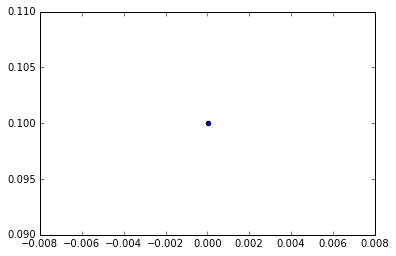

In [65]:
def saveL(resL):
    if not os.path.isfile('resList.ers'):
        with open('resList.ers','wb') as f:
            pickle.dump(resL,f)

resList.sort(key=lambda x: x[2])
resLista=np.array(resList)

saveL(resLista)


print(resLista[:5])
plt.scatter(resLista[:1,0],resLista[:1,1])

In [26]:
"""oldDist is no turn Ang on the error , while dist is turned error """
print(("Different values with turnAng Error {}, "
      +"\nnumber of spikes noturnAng {}, "
       +"\nnumber of spikes with turnAng {}, nymber of spikes noturnAng, bellow 6: {}").format(
        np.sum(oldDist!=dist,0),
                np.sum(np.absolute(oldDist[:,2])>1),
                np.sum(np.absolute(dist[:,2])>1),
        np.sum( (np.absolute(oldDist[:,2])>1) & (np.absolute(oldDist[:,2])<6) )))
koiS=np.where( (np.absolute(oldDist[:,2])>1) & (np.absolute(oldDist[:,2])<6) )
koiSS=np.where(np.absolute(dist[:,2])>1)
print(dist[koiS,2],oldDist[koiS,2])


Different values with turnAng Error [  0   0 250], 
number of spikes noturnAng 260, 
number of spikes with turnAng 22, nymber of spikes noturnAng, bellow 6: 25
[[-1.48083784717  -1.594529698919  2.727659691366 -1.335071043512
  -2.920931186686 -1.906321809237  1.236398628181 -0.780500475971
   1.817290196811  2.708644369315 -2.484070544827  0.459993415109
  -2.337506757562 -1.990935540693  0.925820980012 -2.089232018515
   1.965220702891 -1.955604023585  2.453370453321 -1.955645627336
   3.097262912841 -2.798998653075  1.589832017223  1.906153906731
  -1.629228378786]] [[ 4.80234746001   4.688655608261  2.727659691366  4.948114263667
  -2.920931186686  4.376863497943  1.236398628181  5.502684831209
   1.817290196811 -3.574540937865  3.799114762352 -5.823191892071
  -2.337506757562 -1.990935540693 -5.357364327167 -2.089232018515
  -4.317964604289 -1.955604023585 -3.829814853858 -1.955645627336
  -3.185922394339 -2.798998653075 -4.693353289957 -4.377031400449
   4.653956928394]]


In [ ]:
print(6545)